# EuskoFlyx

In this notebook, we are going to implement a simple Content-based Recommender System for movies, to which end we are going to use the [*movielens* dataset](https://grouplens.org/datasets/movielens/). This dataset contains movie rating data, which has been collected from the [MovieLens web site](https://movielens.org).

There are various versions of the dataset, each of which has different amount of elements. In this demo we will use the small dataset, which contains 100,836 ratings and 3,683 tag applications applied to 1,682 movies by 610 users.

In the next sections we will first load and inspect the data and, then, build and test our recommender system.

## Dataset description

The dataset we are using in this demo is organized in several files, but we will only use the following three files:

* **ratings.csv**: It contains the ratings the users gave to the movies. Each line of this file after the header row represents one rating of one movie by one user, and has the following format:

> *userId, movieId, rating, timestamp*

* **movies.csv**: It contains movie information. Each line of this file after the header row represents one movie, and has the following format:

> *movieId, title, genres*

* **tags.csv**: It contains the movie tags. Each line of this file after the header row represents one tag applied to one movie by one user, and has the following format:

> *userId, movieId, tag, timeStamp*


# Connect to my drive folder, which contains the *movielens* dataset

In order to use the *movielens* dataset, we must first connect to our *drive* folder, and specify the *path* to the files of the dataset.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/LAP/Subjects/AP2/labs

/content/drive/MyDrive/LAP/Subjects/AP2/labs


In [8]:
# Define the path to the folder where the movielens dataset is stored in (set YOUR OWN data_dir PATH)
data_dir = '../data/movielens/'
ratings_file = data_dir + 'ratings.csv'
tags_file = data_dir + 'tags.csv'
movies_file = data_dir + 'movies.csv'

# Load the data

Import the required libraries

In [4]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import defaultdict
import re

Before loading the data from the corresponding CSV files, we are going to implement a class that will keep the information of the movies (id, title, year and text representation).

In the current implementation, the textual representation of the movie will only include the genres. The tags which were assigned to the movies by the users are ignored. However, these tags could benefit the recommending process. You can include this information (just uncomment the corresponding lines and replace the *return* statement in method *genres_and_tags_to_string*) to observe how they affect the recommendations.

In [5]:
# Define a class that contains the metadata of the movie catalog
class MovieData:

    def __init__(self, movieFile, tagFile):
        self.tag_encoding = defaultdict()
        self.loadAndProcessData(movieFile, tagFile)

    def loadAndProcessData(self, movieFile, tagFile):
        movie_data = pd.read_csv(movieFile)
        tag_data = pd.read_csv(tagFile)

        ## Process tags
        movie_tags = defaultdict(list)
        for movieId, tag in zip(tag_data["movieId"], tag_data["tag"]):
            movie_tags[movieId].append(self.encodeTag(tag))

        def cleanTitle(row):
            title = row['title']
            yearPattern = re.compile(r"(?:\((\d{4})\))?\s*$")
            return yearPattern.sub("", title)

        def getYear(row):
            title = row['title']
            yearPattern = re.compile(r"(?:\((\d{4})\))?\s*$")
            yearMatch = yearPattern.search(title)
            year = yearMatch.group(1)
            return year

        def genres_and_tags_to_string(row):
            movieId = row['movieId']
            genres = row['genres']
            genres = ', '.join(g for g in genres.split("|"))
            #tags = ', '.join(t for t in movie_tags[movieId])
            #return "{}, {}".format(genres, tags)
            return genres

        movie_data['year'] = movie_data.apply(getYear, axis = 1)
        movie_data['title'] = movie_data.apply(cleanTitle, axis = 1)
        movie_data['representation'] = movie_data.apply(genres_and_tags_to_string, axis = 1)

        ## Remove unnecesary columns
        movie_data.drop('genres', axis='columns', inplace=True)

        self.movie_data = movie_data
        self.movie2idx = pd.Series(movie_data.index, index=movie_data['movieId'])
        self.movieIds = np.unique(movie_data['movieId'])

    def getMovieIds(self):
        return self.movieIds

    def getMovieIdx(self, movieId):
        idx = self.movie2idx[movieId]
        if type(idx) == pd.Series:
            idx = idx.iloc[0]
        return idx

    def encodeTag(self, tag):
        tag = tag.lower()
        if not tag in self.tag_encoding:
            encodedTag = "tag{}".format(len(self.tag_encoding))
            self.tag_encoding [tag] = encodedTag
        return self.tag_encoding [tag]

    def decodeTag(self, tag):
        tag = tag.lower
        if tag in self.tag_encoding:
            return self.tag_encoding[tag]
        else:
            ## Tag was not encoded, return tag
            return tag

    def getMovieRepresentations(self):
        return self.movie_data['representation']

    def getMovieInfo(self, movieId):
        idx = self.getMovieIdx(movieId)
        movie = self.movie_data.iloc[idx]

        return {'movieId': movie['movieId'],
                'title': movie['title'],
                'year': movie['year']}

Let's load the date and inspect the available information. On the one hand, we will obtain the information about the movies. On the other hand, we will also get the ratings of the user, which will allow the recommender system to infer the preferences of the users.


In [9]:
## Load movie data and rating data. The latte
movieData = MovieData(movies_file, tags_file)
movieRatings = pd.read_csv(ratings_file)

Next, we will explore how the ratings are distributed.

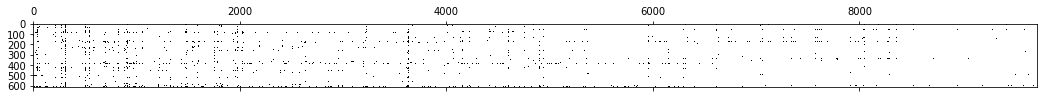

In [10]:
user_movie_rating = movieRatings.pivot_table(index='userId', columns='movieId', values='rating')

fig = plt.figure(figsize=(18, 18))
plt.spy(user_movie_rating)

As can be observed, we are dealing with a very sparse rating matrix. This is positive considering the business perspective. There are a lot of items that may interest the user and that the user is not aware. On the other hand, the information we have a about (some) users is very limited. In fact, we can only be sure whether or not the recommendations are appropriate for those items the user actually rated.

# Building our Content-based Recommender System
This recommender system will use TF-IDF to model the movies. The preferences will be inferred from the movies the users liked (rating >= 3.5).


In [14]:
class TFIDF_CBFRecommender:

    def __init__(self, movieData, threshold):
        self.movie_data = movieData
        self.threshold = threshold
        # Create the TF-IDF of the movies
        self.movie_models = self.__createMovieTFIDFModel(self.movie_data.getMovieRepresentations())

    def __createMovieTFIDFModel(self, movieRepresentations, maxFeatures=2000):
        tfidf = TfidfVectorizer(max_features = maxFeatures)
        return tfidf.fit_transform(movieRepresentations)

    def __getMovieModel(self, movieId):
        movieIdx = self.movie_data.getMovieIdx(movieId)
        return self.movie_models(movieIdx)

    def __getUserModel(self, userId):
        return self.user_models[userId]

    def __getTargetMoviesForUser(self, userId):
        if userId not in self.user_models.keys():
            raise Exception("User Unknown")
        ratedMovies = self.user_rated_movies[userId]
        return list(set(self.movie_data.getMovieIds()) - set(ratedMovies))

    def fit(self, trainData):
        userModels = {}
        userRatedMovies = defaultdict(list)
        # process train data to infer the user models
        data = zip(trainData['userId'], trainData['movieId'], trainData['rating'])
        for userId, movieId, rating in data:
            userRatedMovies[userId].append(movieId)
            if rating >= self.threshold:
                movieModel = self.__getMovieModel(movieId)
                if userModels[userId] is None:
                    userModels[userId] = movieModel
                else:
                    userModels[userId] = userModels[userId] + movieModel
        self.movie_models = userModels
        self.user_rated_movies = userRatedMovies

    def predict(self, userId, movieId):
        if userId not in self.user_models.keys() or movieId not in self.movie_data.getMovieIds:
            raise Exception("User or movie unknown")
        # Obtain the user model ans the movie model and compare them
        userModel = self.__getUserModel(userId)
        movieModel = self.__getMovieModel(movieId)
        adequacy = cosine_similarity(userModel, movieModel)[0,0]
        return adequacy

    def getRecommendationsForUser(self, userId, n=10):
        if userId not in self.user_models.keys():
            raise Exception("User unknown")
        targetMovies = self.__getTargetMoviesForUser(userId)
        predictions = [self.predict(userId, movieId) for movieId in targetMovies]
        sortedByRanking = sorted(predictions, key = lambda tup: tup[1], reverse=True)
        return sortedByRanking[:n]
    
    # Return all user models
    def getUserModels(self):
        return self.user_models

## Train and Test the Recommender System

A Recommender System must be able to recommend items the user has not previously consume. In order to analyse if the Recommender System is working, the rating dataset will be split into the *training* and the *test* set.

In [12]:
def getTrainAndTestSets(data, proportion=0.8):
    ranks = data.groupby('userId')['timestamp'].rank(method='first')
    counts = data['userId'].map(data.groupby('userId')['timestamp'].apply(len))
    select = (ranks / counts) > proportion

    trainset = data[select == False]
    testset = data[select]

    return trainset, testset


train_set, test_set = getTrainAndTestSets(movieRatings)

Once the *train set* and the *test set* have been defined, we can run the recommender system, using the *train set* to learn the preferences of the users and the *test set* to determine if the recommendations might be appropriate.

### Use the train set to learn the preferences of the users

In [17]:
recommender = TFIDF_CBFRecommender(movieData, 3.5)
recommender.fit(train_set)

TypeError: ignored

### Use the test set to evaluate the estimation of adequacy of the items

In [ ]:
predictedAddequacies = []
realAddequacies = []

for userId, movieId, rating in zip(test_set['userId'], test_set['movieId'], test_set['rating']):
    realAddequacy = rating > 3.5
    realAddequacies.append(realAddequacy)
    try:
        addequacyScore = recommender.predict(userId, movieId)[1]
        addequacy = addequacyScore > 0.3
    except Exception:
        addequacy = False
    predictedAddequacies.append(addequacy)

cm = confusion_matrix(realAddequacies, predictedAddequacies)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels= ['False', 'True'])
disp.plot()
plt.show()

## Get the recommendations for a particular user

In the previous section, we measured the appropriateness of the recommendations. However, this procedure has some limitations. We do not really know whether or not the users disliked the movies they did not rate. On the other hand, we have used some fixed thresholds to *infer liked movies*. However, the users may use different rating ranges.

Observing the recommendations might be appropriate to see the suggestions the users receive.

In [ ]:
recommender.fit(movieRatings)
recommendationsForUser82 = recommender.getRecommendationsForUser(82)

for movieId, addequacy in recommendationsForUser82:
    movieInfo = movieData.getMovieInfo(movieId)
    title = movieInfo['title']
    print("Movie ID: {}, Title: {} Addequacy: {}".format(movieId, title, addequacy))

The suggestions can be compared to the items the user really liked. This way we could see whether or not they look appropriate. 

In [ ]:
print("Movied liked by user 82")
for userId, movieId, rating in zip(movieRatings['userId'], movieRatings['movieId'], movieRatings['rating']):
    if userId == 82 and rating > 3.5:
        movieInfo = movieData.getMovieInfo(movieId)
        title = movieInfo['title']
        print("Movie Id: {} Title: {} Rating: {}".format(movieId, title, rating))

# Exercises

The following exercises will allow you to practice on the development of Content-based Recommender Systems.

## Using normalized ratings

In the *demo*, we have implemented a Recommender System that considers that users liked a movie if the rating equals or is greater thatn 3.5. However, they may be more lenient or harsher. Try using **user mean normalized** ratings to infer which movies the users liked (e.g., 0.5 points above the average).

Normalized ratings are computed by subtracting the average rating of the user to each rating.

$r'_{u,i} = r_{u,i} - \overline{r}_u$


In [ ]:
## Implement and test a CB Recommender Systems which uses normalized ratings

## Represent the user model using the list of movies

Some authors, instead of using vector space to represent the preferences of the users, only use the list of consumed movies. In this approach, the recommender predicts the rating the user would give to a movie with the following formula

$\hat{r}_{u,i}=\frac{\sum_{j \in N_u}r_{u,j}*sim(i,j)}{\sum_{j \in N_u}sim(i,j)}$

## Do tags improve the performance of the Recommender System?

Try using the tags in addition to the genre list to observer how they affect recommendations.

## Using Latend Dirichlet Allocation (LDA) to model movies and the preferences of the users

Try using LDA instead of TF-IDF to model the items. In this scenario, items have few textual information, so this approach may have limited benefits, but can be very usefull in other scenarios (e.g., recommendation of scientific papers).